In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydicom as dicom

In [9]:
!pip install pydicom

     ---------------------------------------- 1.8/1.8 MB 4.3 MB/s eta 0:00:00


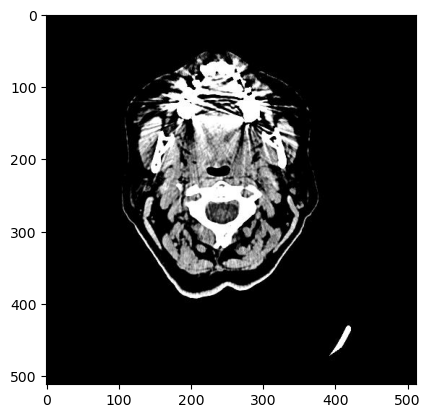

In [6]:
import matplotlib.image as img
image = img.imread("./files/aneurysm/0.jpg")
plt.imshow(image)

In [7]:
image.shape

(512, 512, 3)

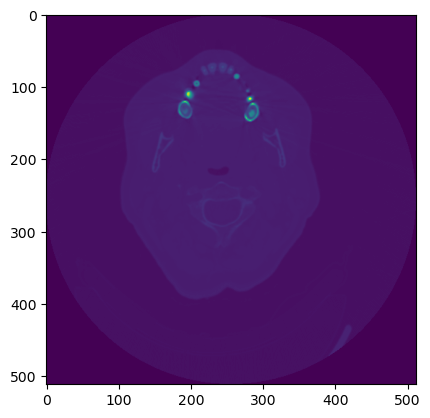

In [12]:
ds = dicom.dcmread("./files/aneurysm/0.dcm")
plt.imshow(ds.pixel_array)

# Load the Image Name

In [13]:
ds = tf.data.Dataset.list_files('./files/*/*.jpg', shuffle=False)

## Load Image Dataset from Folder

In [14]:
IMAGE_SIZE = 516
BATCH = 32
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./files",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH
)

Found 259 files belonging to 3 classes.


In [15]:
class_ = dataset.class_names
class_

['aneurysm', 'cancer', 'tumor']

(516, 516, 3)


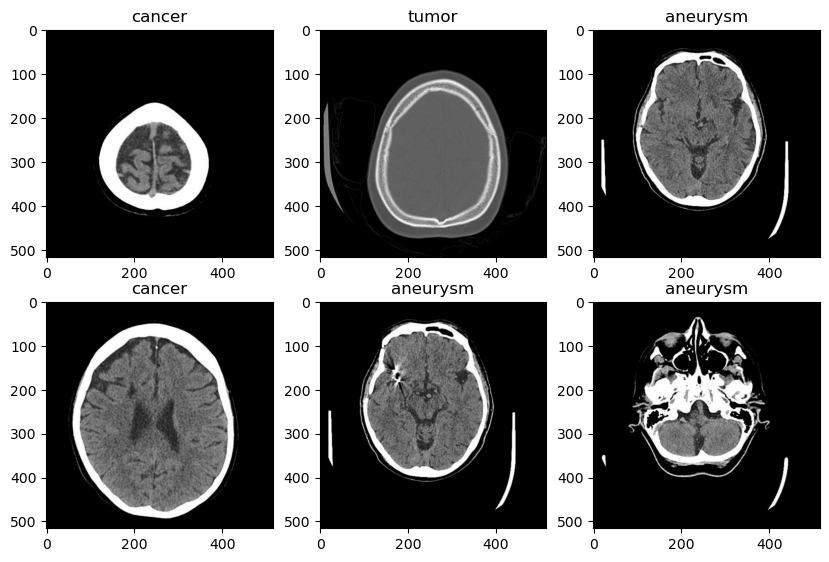

In [16]:
for img,label in dataset.take(1):
    print(img[0].shape)
    plt.figure(figsize=(10,10))
    for i in range(6):        
        plt.subplot(3,3,i+1)
        plt.title(class_[label[i]])
        plt.imshow(img[i].numpy().astype("uint8"))

In [17]:
def split_train_test_val(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=False):
    ds_size = len(ds)
    train_size = round(train_split*ds_size)
    test_size = round(test_split*ds_size)
    val_size = round(val_split*ds_size)
    if shuffle:
        ds = ds.shuffle()
        
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    return train_ds,test_ds,val_ds

In [18]:
train_ds,test_ds,val_ds = split_train_test_val(ds=dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


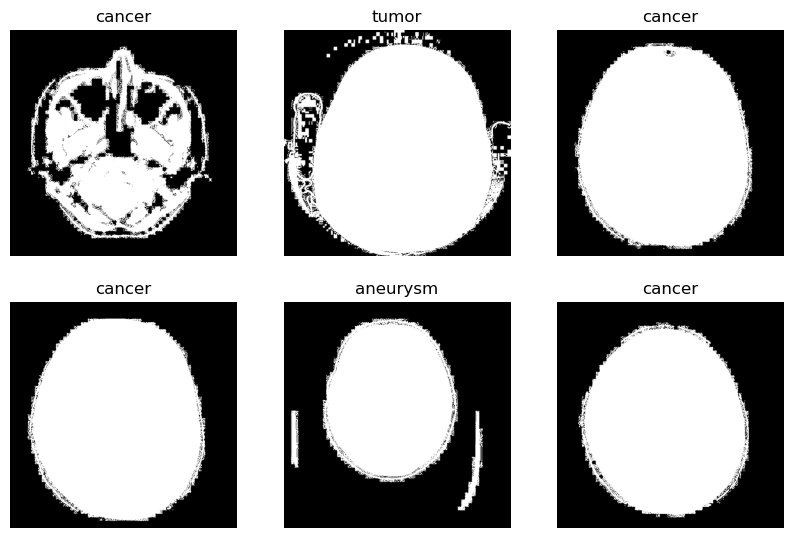

In [19]:
for batch , label in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for idx in range(6):
        plt.subplot(3,3,idx+1)
        plt.imshow(batch[idx].numpy())
        plt.title(class_[label[idx].numpy()])
        plt.axis("off")

In [20]:
tarin_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
from tensorflow.keras import models,layers

image_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE,
    interpolation='bilinear',
    crop_to_aspect_ratio=False),
    layers.Rescaling(1./255),
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
])

In [22]:
input_size = (BATCH,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    image_preprocessing,
    layers.Conv2D(32,(8,8),activation='relu',input_shape=input_size),
    layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
    layers.Conv2D(64,kernel_size=(4,4),activation='relu'),
    layers.Dropout(.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_),activation='softmax')
])

model.build(input_shape=input_size)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 516, 516, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 509, 509, 32)        6176      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 254, 254, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 251, 251, 64)        32832     
                                                                 
 dropout (Dropout)           (32, 251, 251, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (32, 249, 249, 64)        36928     
                                                      

In [29]:
!pip install pydot
!pip install graphviz 

     -------------------------------------- 47.0/47.0 kB 584.1 kB/s eta 0:00:00


In [30]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=90
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [31]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 50
history = model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds,verbose=1)

Epoch 1/50
7/7 [==============================] - 143s 20s/step - loss: 4.8091 - accuracy: 0.6295 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/50
3/7 [===========>..................] - ETA: 1:41 - loss: 0.3442 - accuracy: 0.9375

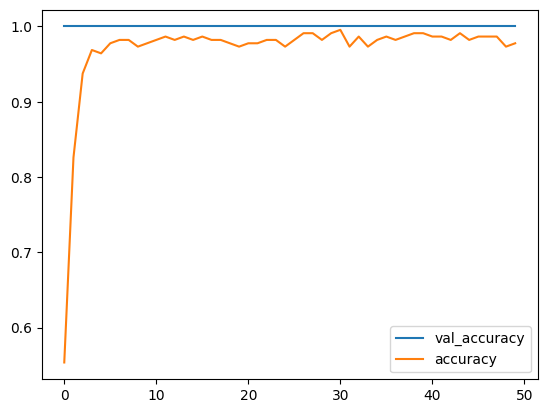

In [20]:
train_hist = history.history
epochs = list(range(EPOCHS))
plt.plot(epochs,train_hist['val_accuracy'],label="val_accuracy")
plt.plot(epochs,train_hist['accuracy'],label="accuracy")
plt.legend(loc="lower right")

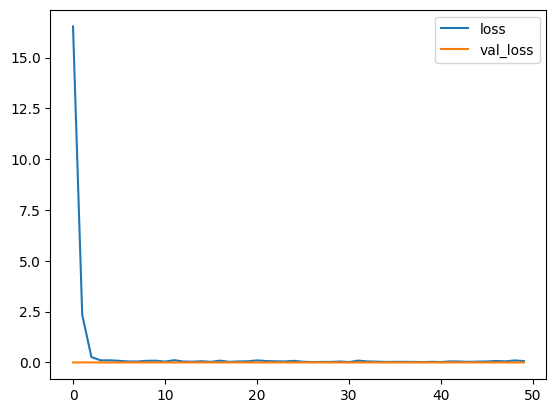

In [21]:
plt.plot(epochs,train_hist['loss'],label="loss")
plt.plot(epochs,train_hist['val_loss'],label="val_loss")
plt.legend(loc="upper right")

In [22]:
score = model.evaluate(test_ds)

1/1 [==============================] - 1s 790ms/step - loss: 0.0028 - accuracy: 1.0000


In [23]:
score

[0.002773221116513014, 1.0]

1/1 [==============================] - 0s 118ms/step


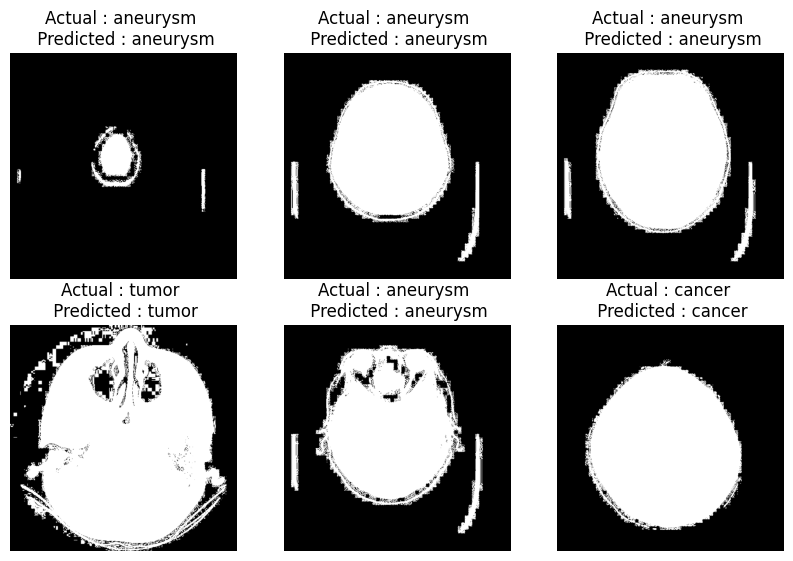

In [24]:
for img,label in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        pred = model.predict(img.numpy())
        plt.title(f"Actual : {class_[label.numpy()[i]]} \n Predicted : {class_[np.argmax(pred[i])]}")
        plt.imshow(img[i].numpy())
        plt.axis("off")

In [25]:
model.save("model1.keras")